This notebook makes use of a skill list that is used to loop through job descriptions. At the end, we will have a skill list with numbers attached to it, so we can check the most frequently mentioned skills through all job descriptions. 
At a later point, the skill list can be produced by running gsearch_3_NLP_full notebook.

In [33]:
#loading data from sql to python
import sql_functions as sf
from dotenv import load_dotenv
import sqlalchemy
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # adds % signs to the y axis
import numpy as np

plt.style.use('fivethirtyeight')

In [2]:
# load "other skill list"
schema = 'capstone_datacvpro'

df_skills = sf.get_dataframe(f' SELECT * FROM {schema}.skills_count_20') # skill table
# remove white spaces
df_skills["skill_clean"] = df_skills["skill_clean"].apply(lambda x: x.strip())
display(df_skills[df_skills["skill_clean"].str.contains("sql ")])
display(df_skills)

,skill,skill_clean,count,type,frequency_%
308,SQL Server Integration Services (SSIS),sql server integration services,8,Hard Skill,0.36
422,Microsoft SQL Servers,microsoft sql servers,0,Hard Skill,0.00
502,Web SQL Databases,web sql databases,0,Hard Skill,0.00
520,Oracle SQL Developer,oracle sql developer,0,Hard Skill,0.00


,skill,skill_clean,count,type,frequency_%
0,SQL (Programming Language),sql,1389,Hard Skill,61.65
1,Communications,communication,1154,Soft Skill,51.22
2,Source (Game Engine),source,1051,Hard Skill,46.65
3,Data Analysis,data analysis,717,Hard Skill,31.82
4,Python (Programming Language),python,637,Hard Skill,28.27
...,...,...,...,...,...
523,Economic Statistics,economic statistics,0,Hard Skill,0.00
524,JIRA Studio,jira studio,0,Hard Skill,0.00
525,Peoplesoft Human Resources,peoplesoft human resources,0,Hard Skill,0.00
526,Zope (CMS),zope,0,Hard Skill,0.00


In [4]:
#df_skills.to_csv("data/skills_count_20.csv", index = False)

In [ ]:
# import the clean dataframe
df_main = pd.read_csv("data/df_clean_for_token.csv")
df_main = df_main.drop("index", axis=1)
df_main.head()

In [ ]:
# make a list of the df_skills in order to loop with it
skills_list_clean = df_skills['skill_clean'].to_list()

# # create new columns for each skill
# # works perfectly, but produces warnings because columns are being concated 1 by 1, the beneath code avoids this issue
# for skill in skills_list_clean:
#     df_main[skill] = df_main['description'][0:10].apply(lambda x: 1 if skill.lower() in x.lower() else 0)


# #new code that avoids warnings during concat
new_dfs = []

for skill in skills_list_clean:
    new_df = df_main.copy()
    new_df[skill] = new_df['description'].apply(lambda x: 1 if skill.lower() in x.lower() else 0).astype(int)
    new_df = new_df.drop(["description", "date_time"], axis = 1)  # Create a copy of the original DataFrame
    new_dfs.append(new_df)

# Concatenate all new DataFrames along the columns
df_main = pd.concat([df_main] + new_dfs, axis=1)
df_main.head()

In [ ]:
# save as raw here
#df_main.to_csv("data/df_skills_raw.csv", index = False)
#df_main.shape

In [5]:
df_main = pd.read_csv("data/df_skills_raw.csv")

In [6]:
# e,r,m,c,b are supposed to be programming languages, but are being counted as part of other words, need to be dropped and looked at seperately in a later section
# droping columns r,e,m,c,b
print(df_main.shape) # should be 530
df_exp1 = df_main.drop(["R","E","M","C","B"], axis = 1)# names include a white space!
print(df_exp1.shape) # should be 530 - 5

(32022, 530)
(32022, 525)


In [7]:
# extract standalone characters that are programming languages r,e,m,c,b
def has_standalone_r_e_m_c_b(text):
    words = text.split()
    return {'R': 'r' in words, 'E': 'e' in words, 'M': 'm' in words, 'C': 'c' in words, 'B': 'b' in words}

# apply the function to the "description" column and expand the result into separate columns (by .apply(pd.Series))
df_exp1[['R', 'E', 'M', 'C', 'B']] = df_exp1['description'].apply(has_standalone_r_e_m_c_b).apply(pd.Series)

# counting based on boolean mask
df_exp1[df_exp1["R"]]
print(len(df_exp1[df_exp1["R"]]), len(df_exp1[df_exp1["E"]]), len(df_exp1[df_exp1["M"]]), len(df_exp1[df_exp1["C"]]), len(df_exp1[df_exp1["B"]]))

# making a small table 
display(df_exp1[["R", "E", "M", "C", "B"]].sum(axis=0).sort_values(ascending = False))
print(df_exp1.shape) # should be back to 531

2245 169 94 196 132


R    2245
C     196
E     169
B     132
M      94
dtype: int64

(32022, 530)


In [8]:
# replacing booleans with numbers
df_exp1[["R", "E", "M", "C", "B"]] = df_exp1[["R", "E", "M", "C", "B"]].replace(True, 1).replace(False, 0)
display(df_exp1)

,description,date_time,sql,communication,source,data analysis,python,computer science,tableau,statistics,...,economic statistics,jira studio,peoplesoft human resources,zope,constructability,R,E,M,C,B
0,"as the leader in cloud-managed it, cisco merak...",2023-08-02 03:00:13.054897,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,as a senior business analyst you will contribu...,2023-08-02 03:00:13.054897,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,overview:\n\namyx is seeking to hire a data an...,2023-08-02 03:00:13.054897,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,i am looking for someone to help me build an a...,2023-08-02 03:00:13.054897,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,position vacancy – data analyst to support the...,2023-08-02 03:00:13.054897,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32017,kforce has a client that is seeking a senior d...,2023-04-29 03:00:20.950789,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32018,"at edward jones, we help clients achieve their...",2022-11-24 04:00:08.710801,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32019,"at edward jones, we help clients achieve their...",2022-12-07 04:00:12.563831,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32020,"at edward jones, we help clients achieve their...",2022-12-08 04:00:15.975728,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# droping description as it is not needed any longer 
df_exp1 = df_exp1.drop("description", axis = 1)

In [10]:
# looking at skills in preparation to exclude some
exclude_columns = ["date_time"]
sum_result = df_exp1.loc[:, ~df_exp1.columns.isin(exclude_columns)].sum()
display(sum_result.sort_values(ascending= False))

sql                           18351
communication                 16024
source                        15669
data analysis                 13207
visualization                 11400
                              ...  
controllability                   0
operations support systems        0
customer support analyst          0
idealization                      0
scholastic read 180               0
Length: 528, dtype: int64

In [11]:
non_zero_sum_result = sum_result[sum_result != 0].sort_values(ascending=False)
display(non_zero_sum_result)

sql                         18351
communication               16024
source                      15669
data analysis               13207
visualization               11400
                            ...  
indexer                         1
use case diagram                1
data encryption standard        1
life insurance sales            1
mathematical statistics         1
Length: 449, dtype: int64

In [12]:
zero_sum_result = sum_result[sum_result == 0].sort_values(ascending=False)
display(zero_sum_result)

extensible markup language                                            0
storages                                                              0
registration evaluation authorisation and restriction of chemicals    0
itext                                                                 0
hyperion financial reporting                                          0
                                                                     ..
data mapper patterns                                                  0
data explorers                                                        0
java data mining                                                      0
environmentalism                                                      0
zope                                                                  0
Length: 79, dtype: int64

In [13]:
# preparing a skill table independent from time
# this table will be used to compared the skill sets from the current data set to the jobs2020 dataset
# will be used to drop skills with low count
df_skill_count = df_exp1.copy()
df_skill_count = df_skill_count.drop(["date_time"], axis = 1)
df_skill_count.head()

,sql,communication,source,data analysis,python,computer science,tableau,statistics,research,dashboard,...,economic statistics,jira studio,peoplesoft human resources,zope,constructability,R,E,M,C,B
0,1,0,0,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Making a simple table of cleaned skills and counts
sum_skills = []
# for each skill take a sum of the column
for skill_clean in df_skill_count.columns:
    sum = df_skill_count[skill_clean].sum()
    sum_skills.append({'skill_clean': skill_clean, 'count' : sum})

skills_count_clean = pd.DataFrame(sum_skills)
skills_count_clean.sort_values("count", ascending = False)

,skill_clean,count
0,sql,18351
1,communication,16024
2,source,15669
3,data analysis,13207
10,visualization,11400
...,...,...
401,controllability,0
463,operations support systems,0
462,customer support analyst,0
402,idealization,0


In [15]:
# rename column
df_skill_count = skills_count_clean.rename(columns = {"count": "count_current"})
# add column with %
df_skill_count["frequency_%_current"] = df_skill_count["count_current"].apply(lambda x: x/(len(df_exp1))*100).round(2) #
df_skill_count = df_skill_count.sort_values('frequency_%_current', ascending=False).reset_index(drop=True)
df_skill_count.head()

,skill_clean,count_current,frequency_%_current
0,sql,18351,57.31
1,communication,16024,50.04
2,source,15669,48.93
3,data analysis,13207,41.24
4,visualization,11400,35.60


In [16]:
# Dropping columns from the dataset that contains date_time for further cleaning
# setting a THRESHOLD of 1% (32022/100 = 320)  if a skill appears less than 320, then drop
# 448 total skills 
skills_threshold_1perc = skills_count_clean["skill_clean"][skills_count_clean["count"] < 320]  
skills_threshold_1perc = skills_threshold_1perc.tolist()
display(len(skills_threshold_1perc))

296

In [17]:
# 232 skills remain
df_1percent = df_exp1.drop(skills_threshold_1perc, axis = 1)
df_1percent.head()

,date_time,sql,communication,source,data analysis,python,computer science,tableau,statistics,research,...,market data,exploratory data analysis,mobility,benchmarking,query languages,adaptability,sustainability,long-term care,retirement planning,R
0,2023-08-02 03:00:13.054897,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2023-08-02 03:00:13.054897,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2023-08-02 03:00:13.054897,1,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2023-08-02 03:00:13.054897,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023-08-02 03:00:13.054897,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
merging_skills = df_1percent.drop(["date_time"], axis = 1)
merging_skills = merging_skills.columns.tolist()
display(merging_skills, len(merging_skills))

['sql',
 'communication',
 'source',
 'data analysis',
 'python',
 'computer science',
 'tableau',
 'statistics',
 'research',
 'dashboard',
 'visualization',
 'track',
 'writing',
 'programming',
 'presentation',
 'data quality',
 'sas',
 'finance',
 'data management',
 'leadership',
 'business intelligence',
 'data visualization',
 'analytical skills',
 'dataset',
 'project management',
 'git',
 'planning',
 'data collection',
 'written communication',
 'sales',
 'data mining',
 'integration',
 'data science',
 'collaboration',
 'business requirements',
 'problem solving',
 'information systems',
 'consulting',
 'automation',
 'business process',
 'microsoft office',
 'tracking',
 'java',
 'economics',
 'innovation',
 'transformation',
 'infrastructure',
 'information technology',
 'accounting',
 'machine learning',
 'power bi',
 'acting',
 'scale',
 'data governance',
 'data integrity',
 'data modeling',
 'big data',
 'mapping',
 'supervision',
 'financial services',
 'decision maki

232

Manually deleting skills that do not belong
deleted list = 

['source', 'track', 'business requirements', 'business process', 'innovation', 'acting', 'mapping', 'tracking', 'scale', 'timelines', 'investigation', 'stored procedure', 'customer experience', 'nice', 'process improvements', 'diversity and inclusion', 'requisition', 'sourcing', 'functional requirement', 'transparency', 'onboarding', 'authorization', 'security clearance', 'perspective', 'numbers', 'business model', 'secret clearance', 'professional services', 'medicaid', 'mobility', 'benchmarking', 'workday', 'qlikview', 'long-term care', 'retirement planning', 'data analysis', 'business intelligence']


In [19]:
# creating a listof skills after manually removing skills that made "no sense"
# 195
manual_list_1 = ['communication', 'sql', 'computer science', 'statistics', 'research', 'dashboard', 'visualization', 'writing', 'presentation', 'data quality', 'finance', 'data management', 'leadership', 'programming', 'data visualization', 'analytical skills', 'dataset', 'project management', 'planning', 'python', 'data collection', 'written communication', 'sales', 'data mining', 'tableau', 'integration', 'data science', 'collaboration', 'problem solving', 'information systems', 'consulting', 'automation', 'microsoft office', 'economics', 'infrastructure', 'information technology', 'accounting', 'power bi', 'machine learning', 'data governance', 'data integrity', 'data modeling', 'big data', 'supervision', 'sas', 'financial services', 'decision making', 'data system', 'scripting', 'metadata', 'customer service', 'microsoft excel', 'organizational skills', 'relational databases', 'verbal communication skills', 'banking', 'database design', 'forecasting', 'time management', 'quality assurance', 'reporting tools', 'critical thinking', 'transformation', 'business analysis', 'troubleshooting', 'quality control', 'algorithms', 'software development', 'statistical packages', 'curiosity', 'data warehousing', 'data engineering', 'data entry', 'coordinating', 'data integration', 'mysql', 'detail oriented', 'workflows', 'reconciliation', 'informatics', 'business intelligence tools', 'data pipeline', 'supply chain', 'financial data', 'creativity', 'accountability', 'business analytics', 'data architecture', 'macros', 'data profiling', 'information management', 'reliability', 'data processing', 'business administration', 'statistical software', 'data element', 'data validation', 'data extraction', 'public health', 'google analytics', 'data mapping', 'risk management', 'data transformation', 'unstructured data', 'prioritization', 'quantitative analysis', 'technology solutions', 'teamwork', 'performance metric', 'quality improvement', 'business acumen', 'raw data', 'spreadsheets', 'management process', 'logistics', 'business operations', 'unix', 'data manipulation', 'management systems', 'intellectual curiosity', 'master data management', 'data structures', 'root cause analysis', 'change management', 'predictive modeling', 'physics', 'data steward', 'user experience', 'stewardship', 'microstrategy', 'statistical methods', 'business systems', 'technical support', 'scheduling', 'templates', 'acceptance testing', 'calculations', 'alteryx', 'operations research', 'auditing', 'product management', 'experience design', 'billing', 'predictive analytics', 'strategic planning', 'data security', 'pl/sql', 'financial analysis', 'real estate', 'key performance indicators', 'digital transformation', 'procurement', 'life sciences', 'surveys', 'professionalism', 'source data', 'program management', 'epidemiology', 'genetics', 'data files', 'e-commerce', 'statistical modeling', 'quality management', 'java', 'application development', 'business development', 'managed care', 'investments', 'spss', 'data cleansing', 'digital marketing', 'scalability', 'experimentation', 'editing', 'database systems', 'population health', 'data migration', 'scrum', 'construction', 'computer engineering', 'prediction', 'financial modeling', 'business strategies', 'budgeting', 'negotiation', 'market data', 'exploratory data analysis', 'query languages', 'snowflake', 'javascript', 'adaptability', 'git', 'sustainability', 'pandas', 'R']
manual_list_1 = list(map(lambda x: x.strip(), manual_list_1))
print(len(manual_list_1))


195


In [20]:
deleted_list = [item for item in merging_skills if item not in manual_list_1]
#print(deleted_list)
print(len(deleted_list))

37


In [21]:
# drop the deleted columns
# 192 skills remain
df_manual_clean = df_1percent.drop(deleted_list, axis = 1)
df_manual_clean.head()

,date_time,sql,communication,python,computer science,tableau,statistics,research,dashboard,visualization,...,business strategies,financial modeling,budgeting,negotiation,market data,exploratory data analysis,query languages,adaptability,sustainability,R
0,2023-08-02 03:00:13.054897,1,0,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2023-08-02 03:00:13.054897,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2023-08-02 03:00:13.054897,1,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2023-08-02 03:00:13.054897,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023-08-02 03:00:13.054897,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


Beneath is a sample data frame  with descriptions and tokenized skilles as 1 and 0.
Here we see how the tokenizer works, namely by using the whole word to scan. This means that
"visualisation" is the umbrella term. Therefore, "data visualization" can be manually deleted/ignored from the list.

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>description</th>
      <th>visualization</th>
      <th>data visualization</th>
      <th>statistics</th>
      <th>statistical</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Data analysis and visualization</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Programming with Python data visualization</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Database management and statistical packages</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Machine learning algorithms and statistics</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Statistical visualizations and charts</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

In [ ]:
exclude_columns1 = ["date_time"]
sum_result1 = df_manual_clean.loc[:, ~df_manual_clean.columns.isin(exclude_columns1)].sum()
print(sum_result1.sort_values(ascending= False)[0:25])

Idea for the future on how to avoid over and underestimation of skills. For example, when a job asks for statistical knowledge, it is likely that it also asks for statistical packages.
It makes sense to count both columns together. The code is ready and beneath and can be implemented in the near future.

Manual adding up statistical skills to be represented in one.
SPSS (Statistical Software)
Statistical Packages
Statistical Software
Statistical Methods	
Statistical Modeling
SAS Statistical Analysis --> check me later, where did it go???

In [31]:
# df_manual_clean["statistics_combined"] = df_manual_clean["statistics"] + df_manual_clean["spss"] + df_manual_clean["statistical packages"] + df_manual_clean["statistical software"] +df_manual_clean["statistical methods"] + df_manual_clean["statistical modeling"] 
# df_manual_clean["statistics_combined"] = np.where(df_manual_clean["statistics_combined"] >= 2, 1, df_manual_clean["statistics_combined"])
# df_manual_clean["statistics_combined"].sum()

top 20 for later

In [ ]:
# sum_result2 = df_manual_clean.loc[:, ~df_manual_clean.columns.isin(exclude_columns1)]#.sum()[0:20]
# sum_result2 = sum_result2.columns.tolist()
# print(len(sum_result2))

In [ ]:
# top20_skills = 
# df_manual_clean_top20 = df_manual_clean.loc[:, df_manual_clean.columns.isin(top20_skills)]
# df_manual_clean.head()

In [37]:
df_manual_clean.to_csv("data/jobs_current_all_skills.csv", index = False)
#df_manual_clean_top25.to_csv("data/jobs_current_skills_top25.csv", index = False)

In [ ]:
# dropped idea, supposed to identify similar word in order to clean further

# def find_similar_strings(strings):
#     similar_strings = {}
    
#     for i, str1 in enumerate(strings):
#         for j, str2 in enumerate(strings):
#             if i != j:  # Avoid comparing the same string
#                 similarity_ratio = fuzz.ratio(str1, str2)
                
#                 # You can adjust the threshold based on your needs
#                 if similarity_ratio > 70:  # Example threshold: 80%
#                     if str1 not in similar_strings:
#                         similar_strings[str1] = []
#                     similar_strings[str1].append(str2)
    
#     return similar_strings

# similar_strings = find_similar_strings(manual_list_1)

# for key, value in similar_strings.items():
#     print(f"{key} is similar to: {', '.join(value)}")

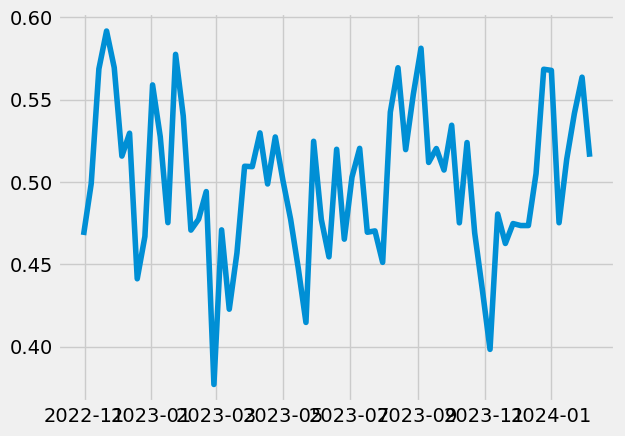

In [38]:
# depict absolutes values of a column across time
df_manual_clean['date_time'] = pd.to_datetime(df_manual_clean['date_time'])
df_manual_clean['week'] = df_manual_clean['date_time'].dt.to_period('W').dt.start_time
plt.plot(df_manual_clean.groupby('week')['communication'].mean())


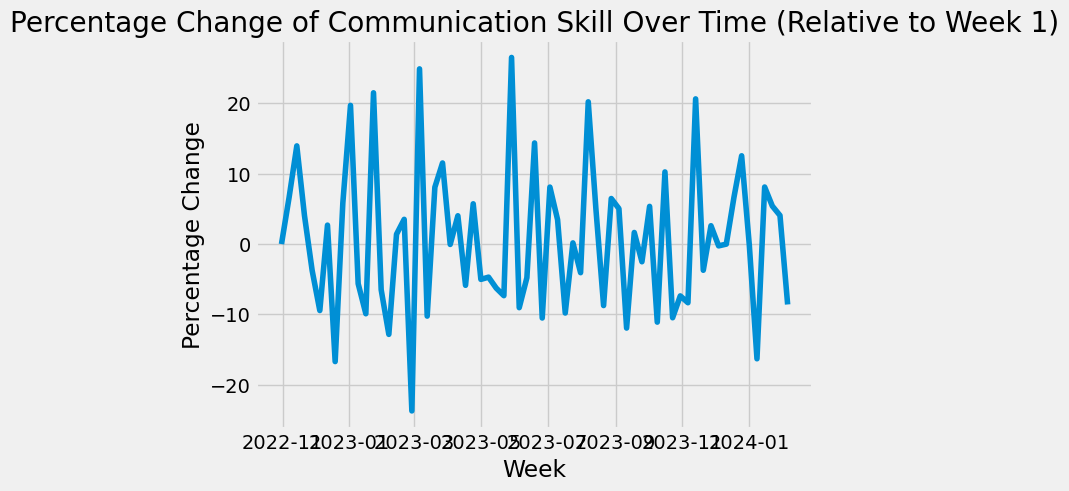

In [39]:
# depicts changes of a value from week to week

df_manual_clean['date_time'] = pd.to_datetime(df_manual_clean['date_time'])
df_manual_clean['week'] = df_manual_clean['date_time'].dt.to_period('W').dt.start_time

# Calculate the mean of the 'communication' skill for each week
mean_communication = df_manual_clean.groupby('week')['communication'].mean()

# Calculate the percentage change from week 1
percentage_change_communication = mean_communication.pct_change() * 100

# Set the percentage change for week 1 to 0 (baseline)
percentage_change_communication.iloc[0] = 0

# Plot the percentage change over time from week 1
plt.plot(percentage_change_communication)
plt.xlabel('Week')
plt.ylabel('Percentage Change')
plt.title('Percentage Change of Communication Skill Over Time (Relative to Week 1)')
plt.show()


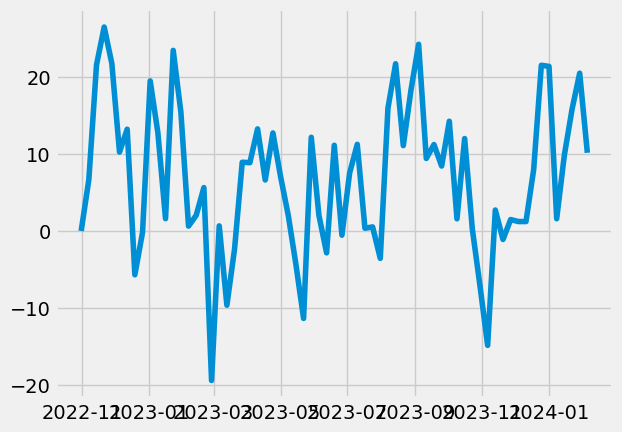

In [40]:
# depicts changes of a value from week to the first week
df_manual_clean['date_time'] = pd.to_datetime(df_manual_clean['date_time'])
df_manual_clean['week'] = df_manual_clean['date_time'].dt.to_period('W').dt.start_time

mean_communication = df_manual_clean.groupby('week')['communication'].mean()

# Calculate percentage change with respect to the first week
percentage_change_communication = (mean_communication / mean_communication.iloc[0] - 1) * 100

# Set the first element to 0
percentage_change_communication.iloc[0] = 0

plt.plot(percentage_change_communication)


In [41]:
import statsmodels.api as sm

# convert 'date_time' to datetime
df_manual_clean['date_time'] = pd.to_datetime(df_manual_clean['date_time'])
# time elapsed since earliest record
df_manual_clean['days_since_start'] = (df_manual_clean['date_time'] - df_manual_clean['date_time'].min()).dt.days

# create sets
X = df_manual_clean[['days_since_start']] # independent var
y = df_manual_clean['data visualization']            # dependent var

# constant term 
X = sm.add_constant(X)

# fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()


print(result.summary())



Optimization terminated successfully.
         Current function value: 0.543113
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:     data visualization   No. Observations:                32022
Model:                          Logit   Df Residuals:                    32020
Method:                           MLE   Df Model:                            1
Date:                Thu, 29 Feb 2024   Pseudo R-squ.:                0.001331
Time:                        14:56:55   Log-Likelihood:                -17392.
converged:                       True   LL-Null:                       -17415.
Covariance Type:            nonrobust   LLR p-value:                 9.913e-12
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.3344      0.026    -52.047      0.000      -1.385      -1.284
days_since_

In [42]:
# convert date_time to months
df_manual_clean['month'] = df_manual_clean['date_time'].dt.to_period('M').dt.start_time

# Group by week and calculate percentage of data_visualization
result = df_manual_clean.groupby('week')['data visualization'].mean() * 100

# Reset index to make week a column again
result = result.reset_index()

# Display the result
print(result)


         week  data visualization
0  2022-10-31           25.495050
1  2022-11-07           25.333333
2  2022-11-14           23.917137
3  2022-11-21           27.715356
4  2022-11-28           14.347826
..        ...                 ...
62 2024-01-08           28.846154
63 2024-01-15           23.425693
64 2024-01-22           24.722222
65 2024-01-29           27.861771
66 2024-02-05           25.357873

[67 rows x 2 columns]


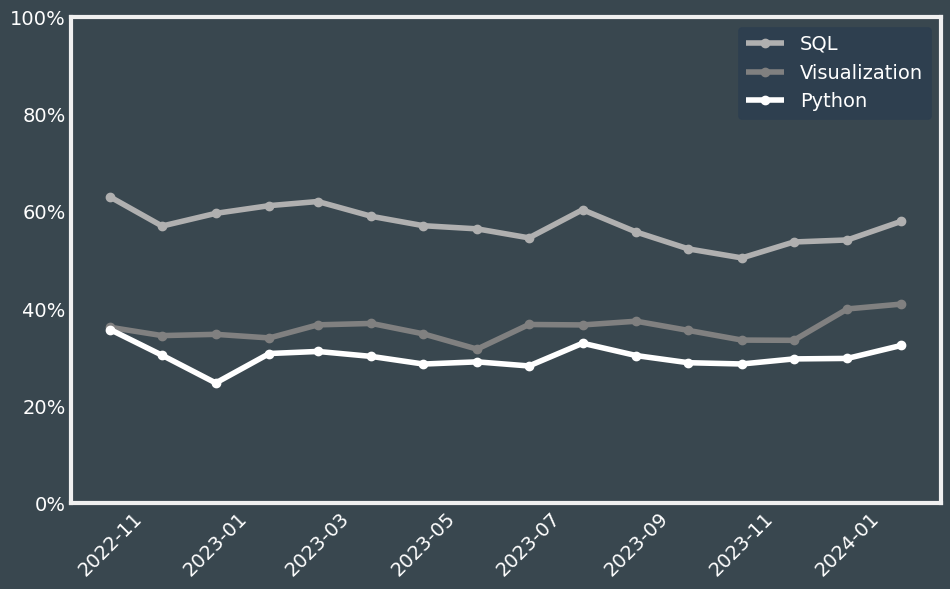

<Figure size 3000x1800 with 0 Axes>

<Figure size 3000x1800 with 0 Axes>

In [47]:
# plotting percentages of value from total jobs (% of 32022)
#creating subplots to hide left,bottom, and right borders
fig, ax = plt.subplots(figsize=(10, 6), facecolor='#39474f', edgecolor='#39474f') 
# Hard skills in percentages
result_sql = df_manual_clean.groupby('month')['sql'].mean() * 100
result_vis = df_manual_clean.groupby('month')['visualization'].mean() * 100
result_py = df_manual_clean.groupby('month')['python'].mean() * 100

# line plot plot 
plt.plot(result_sql.index, result_sql, marker='o', color='#B0B0B0',  label='SQL')
plt.plot(result_vis.index, result_vis, marker='o', color='#808080', label='Visualization')
plt.plot(result_py.index, result_py, marker='o', color='white',  label='Python') # "#C0C0C0"


# adjust legend bg color of the box
legend = ax.legend()
legend.get_frame().set_facecolor('#2C3E50')  # bg color
legend.get_frame().set_edgecolor('#2C3E50')  # border color
# changes text to white
for text in legend.get_texts():
    text.set_color('white')
#plt.xlabel('Month')  # Add x-axis label
#plt.ylabel('Percentages')  # Add y-axis label
#####custom borders, bg
plt.gca().set_facecolor('#39474f')# bg color
ax.tick_params(axis='both', colors='white') #white font for axes
#######
plt.ylim(0, 100) 
plt.grid(False)  # Remove the grid
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
#plt.title("Top 3 Soft skills over time")  # Add plot title
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()
#plt.savefig('data/h_skills_time.png', dpi=300)  # Adjust DPI as needed
plt.figure(figsize=(10, 6), dpi=300)

In [ ]:
# plotting percentages of value from total jobs (% of 32022)
#creating subplots to hide left,bottom, and right borders
fig, ax = plt.subplots(figsize=(10, 6), facecolor='#39474f', edgecolor='#39474f') 

# Soft skills
result_com = df_manual_clean.groupby('month')['communication'].mean() * 100
result_lead = df_manual_clean.groupby('month')['leadership'].mean() * 100
result_pres = df_manual_clean.groupby('month')['presentation'].mean() * 100

plt.plot(result_com.index, result_com, marker='o', color='#FFA500',  label='Communication')
plt.plot(result_lead.index, result_lead, marker='o', color='#ffcc00', label='Leadership')
plt.plot(result_pres.index, result_pres, marker='o', color='#FF7F50',  label='Presentation') # colour of presentation

# adjust legend bg color of the box
legend = ax.legend()
legend.get_frame().set_facecolor('#2C3E50')  # bg color
legend.get_frame().set_edgecolor('#2C3E50')  # border color
# changes text to white
for text in legend.get_texts():
    text.set_color('white')
#plt.xlabel('Month')  # Add x-axis label
#plt.ylabel('Percentages')  # Add y-axis label
#####custom borders, bg
plt.gca().set_facecolor('#39474f')# bg color
ax.tick_params(axis='both', colors='white') #white font for axes
#######
plt.ylim(0, 100)
plt.grid(False)  # Remove the grid 
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
#plt.legend() 
#plt.title("Top 3 Soft skills over time")  # Add plot title
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()
#plt.savefig('data/s_skills_time.png', dpi=300)  # Adjust DPI as needed
plt.figure(figsize=(10, 6), dpi=300)


In [ ]:
# for a quick overview of all skills as written in column, grouped by day, week, or month. Source represents the dataframe
def percentage_plot_time (skill, time, source, color='#FF7F50'):
    source['week'] = source['date_time'].dt.to_period('W').dt.start_time
    source['month'] = source['date_time'].dt.to_period('M').dt.start_time
    source['day'] = source['date_time'].dt.to_period('D').dt.start_time

    result = source.groupby(time)[skill].mean() * 100
    plt.plot(result.index, result, marker='o', color='#FF7F50',  label=skill.capitalize())
    plt.ylim(0, 100) 
    plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
    plt.legend()     
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()    

In [ ]:
sum_result1.sort_values(ascending= False).head(25)

In [ ]:
percentage_plot_time("computer science", "month", df_manual_clean, color='#FF7F50')

TO DO!!!


THIS SECTION IS NOT READY
for the 2020 dataset where the skill list is from, the skills r,c m, b... need to be replaced as in this notebook.

In [ ]:
# merge the 2020 and the current tables
# skills_2020_and_current = pd.merge(df_skill_count, df_skills, on = "skill_clean")
# display(skills_2020_and_current)

In [ ]:
# uploading
# load to database

# df_manual_clean as "jobs_current_skills_timeline"
# df_skill_count as "skill_count_current"

from dotenv import load_dotenv
load_dotenv()

# write dataset into database

# Import get_engine from sql_functions.py. You will need to restart your kernel and rerun at this point since we changed the module since we first imported it.
from sql_functions import get_engine
# create a variable called engine using the get_engine function
engine = get_engine()

import psycopg2

table_name = "jobs_current_all_skills"
schema = 'capstone_datacvpro'

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        df_manual_clean.to_sql(name=table_name, # Name of SQL table variable  
                        con=engine, # Engine or connection
                        schema=schema, # your class schema variable
                        if_exists='replace', # Drop the table before inserting new values 
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None
else:
    print('No engine')

Helping a colleague with visualization

In [ ]:
df_entropy = pd.read_csv("df_entropy.csv")

In [ ]:

keywords = ["SQL", "Communications", "Statistics", "Python", "Computer Science", "Tableau", "Research", "Dashboard", "Visualization", "Writing", "Programming", "Presentations", "Data Quality", "SAS", "Finance", "Data Management", "Leadership", "Analytical Skills", "Project Management", "Git"]# Count the number of occurrences of each keyword in the "username" column
keyword_counts = {keyword: df_entropy['username'].str.contains(keyword).sum() for keyword in keywords}#  frequency in percentage
total_entries = len(df_entropy)
keyword_percentages = {keyword: (count / total_entries) * 100 for keyword, count in keyword_counts.items()}#  results
print("Keyword Counts:")
print(keyword_counts)
print("\nKeyword Percentages:")
print(keyword_percentages)

In [ ]:
keyword_df = df_entropy

In [ ]:
keyword_df = pd.DataFrame.from_dict(keyword_percentages, orient='index', columns=['Percentage'])

# Sort the DataFrame by percentage values in descending order
keyword_df_sorted = keyword_df.sort_values(by='Percentage', ascending=False)

# Plot for ranks 1 to 10
fig, ax = plt.subplots(figsize=(10, 6), facecolor='#39474f', edgecolor='#39474f')

# Set background and edge color
bars = plt.bar(keyword_df_sorted.index[:10], keyword_df_sorted['Percentage'][:10], color='#ffcc00')  # Gold bars

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{i+1}", ha='center', va='bottom', color='darkgray')  # Rank text

# Custom borders, bg
plt.gca().set_facecolor('#39474f')  # Background color
ax.tick_params(axis='both', colors='white')  # White font for axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax.yaxis.grid(False)  # Remove y-axis grid lines
ax.xaxis.grid(False)  # Remove x-axis grid lines

plt.xticks(rotation=45, ha='right', color='white')  # Set x-axis ticks color
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
plt.show()

# Table for ranks 11 to 20
plt.figure(figsize=(8, 6), facecolor='#ffcc00', edgecolor='#39474F')

# Set background and edge color
legend_data = keyword_df_sorted.iloc[10:20].reset_index().values.tolist()
legend_data_with_ranks = [[i+11] + row for i, row in enumerate(legend_data)]  # Add ranks
plt.table(cellText=legend_data_with_ranks, colLabels=['Rank', 'Keyword', 'Percentage'],
          loc='center', cellLoc='center', colLoc='center', colWidths=[0.2, 0.5, 0.5])
plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6), dpi=300)
